# Global Wheat Detection


In [1]:
%pip install -q ultralytics opencv-python scikit-learn scikit-image pandas numpy matplotlib torch


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from ultralytics import YOLO
import torch
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
LABELS_DIR = DATA_DIR / 'labels'


## 1. Evaluation Metrics

Note: Decision Tree (section 3) and Feature Engineering (section 4) are baseline approaches for comparison. Manual CNN (section 5) is educational to understand how CNNs work. The actual detection uses YOLO (sections 6-7).


In [3]:
def iou(box1, box2):
    x1_1 = box1[0] - box1[2] / 2
    y1_1 = box1[1] - box1[3] / 2
    x2_1 = box1[0] + box1[2] / 2
    y2_1 = box1[1] + box1[3] / 2
    
    x1_2 = box2[0] - box2[2] / 2
    y1_2 = box2[1] - box2[3] / 2
    x2_2 = box2[0] + box2[2] / 2
    y2_2 = box2[1] + box2[3] / 2
    
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0


In [4]:
def match_boxes(pred_boxes, gt_boxes, iou_thresh=0.5):
    matches = []
    unmatched_pred = list(range(len(pred_boxes)))
    unmatched_gt = list(range(len(gt_boxes)))
    
    iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, p in enumerate(pred_boxes):
        for j, g in enumerate(gt_boxes):
            iou_matrix[i, j] = iou(p, g)
    
    while True:
        if not unmatched_pred or not unmatched_gt:
            break
        best_iou = 0
        best_p, best_g = None, None
        for p_idx in unmatched_pred:
            for g_idx in unmatched_gt:
                if iou_matrix[p_idx, g_idx] > best_iou:
                    best_iou = iou_matrix[p_idx, g_idx]
                    best_p, best_g = p_idx, g_idx
        if best_iou >= iou_thresh:
            matches.append((best_p, best_g))
            unmatched_pred.remove(best_p)
            unmatched_gt.remove(best_g)
        else:
            break
    
    return len(matches), len(unmatched_pred), len(unmatched_gt)


In [5]:
def load_yolo_label(path):
    boxes = []
    if path.exists():
        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    boxes.append([float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])
    return boxes

image_files = list(TRAIN_DIR.glob('*.jpg'))[:20]
images = []
labels = []

for img_path in image_files:
    img = cv2.imread(str(img_path))
    if img is not None:
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        label_path = LABELS_DIR / f"{img_path.stem}.txt"
        labels.append(load_yolo_label(label_path))


In [6]:
np.random.seed(42)
preds = []
for gt in labels[:10]:
    pred = []
    for box in gt:
        if np.random.random() > 0.1:
            noise = np.random.normal(0, 0.05, 4)
            noisy = [max(0, min(1, box[i] + noise[i])) for i in range(4)]
            noisy[0] = max(noisy[2]/2, min(1 - noisy[2]/2, noisy[0]))
            noisy[1] = max(noisy[3]/2, min(1 - noisy[3]/2, noisy[1]))
            pred.append(noisy)
    for _ in range(len(gt) // 2):
        pred.append([np.random.uniform(0.1, 0.9), np.random.uniform(0.1, 0.9), 
                     np.random.uniform(0.05, 0.15), np.random.uniform(0.05, 0.15)])
    preds.append(pred)

tp_total = fp_total = fn_total = 0
for pred, gt in zip(preds, labels[:10]):
    tp, fp, fn = match_boxes(pred, gt)
    tp_total += tp
    fp_total += fp
    fn_total += fn

precision = tp_total / (tp_total + fp_total + 1e-10)
recall = tp_total / (tp_total + fn_total + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"TP: {tp_total}, FP: {fp_total}, FN: {fn_total}")


Precision: 0.0362
Recall: 0.0500
F1-Score: 0.0420
TP: 18, FP: 479, FN: 342


## 2. Cost-Sensitive Learning


0.1


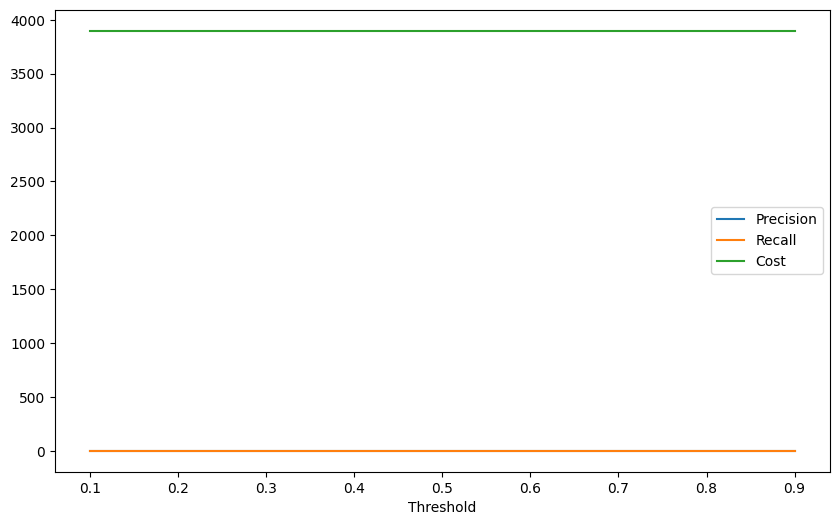

In [7]:
def evaluate_threshold(preds, gts, conf_thresh, iou_thresh=0.5):
    filtered = []
    for p in preds:
        filtered.append([box for box in p if len(box) < 5 or box[4] >= conf_thresh])
    
    tp = fp = fn = 0
    for f, gt in zip(filtered, gts):
        t, fa, fn_val = match_boxes(f, gt, iou_thresh)
        tp += t
        fp += fa
        fn += fn_val
    
    prec = tp / (tp + fp + 1e-10)
    rec = tp / (tp + fn + 1e-10)
    cost = fn * 10 + fp * 1
    return prec, rec, cost

thresholds = np.arange(0.1, 1.0, 0.1)
results = []
for thresh in thresholds:
    prec, rec, cost = evaluate_threshold(preds, labels[:10], thresh)
    results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'cost': cost})

df_results = pd.DataFrame(results)
opt_idx = df_results['cost'].idxmin()
print(df_results.loc[opt_idx, 'threshold'])

plt.figure(figsize=(10, 6))
plt.plot(df_results['threshold'], df_results['precision'], label='Precision')
plt.plot(df_results['threshold'], df_results['recall'], label='Recall')
plt.plot(df_results['threshold'], df_results['cost'], label='Cost')
plt.xlabel('Threshold')
plt.legend()
plt.show()


## 3. Decision Tree


In [8]:
def extract_features(img):
    features = {}
    features['mean_r'] = np.mean(img[:, :, 0])
    features['mean_g'] = np.mean(img[:, :, 1])
    features['mean_b'] = np.mean(img[:, :, 2])
    features['std_r'] = np.std(img[:, :, 0])
    features['std_g'] = np.std(img[:, :, 1])
    features['std_b'] = np.std(img[:, :, 2])
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    features['edge_density'] = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    
    try:
        glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
        features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
        features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    except:
        features['contrast'] = 0
        features['homogeneity'] = 0
    
    return features

X = pd.DataFrame([extract_features(img) for img in images])
y = np.array([1 if len(l) > 0 else 0 for l in labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



## 4. Feature Engineering


In [9]:
def extract_advanced_features(img):
    feat = extract_features(img)
    h, w = img.shape[:2]
    center = img[h//4:3*h//4, w//4:3*w//4]
    feat['center_mean_r'] = np.mean(center[:, :, 0])
    feat['center_mean_g'] = np.mean(center[:, :, 1])
    feat['center_mean_b'] = np.mean(center[:, :, 2])
    return feat

X_advanced = pd.DataFrame([extract_advanced_features(img) for img in images])
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_advanced, y)

selected = X_advanced.columns[rfe.support_].tolist()
print(selected)


['mean_b', 'std_r', 'std_g', 'std_b', 'edge_density', 'contrast', 'homogeneity', 'center_mean_r', 'center_mean_g', 'center_mean_b']


## 5. Manual CNN (Educational - Understanding how CNNs work)


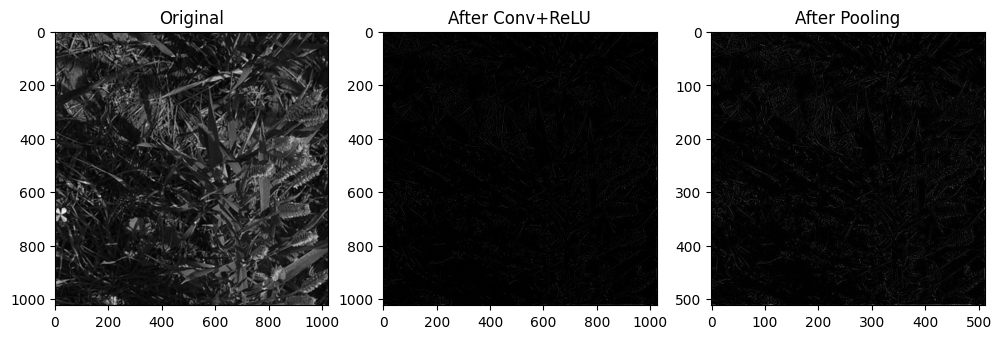

In [10]:
def conv2d(img, kernel, stride=1, padding=0):
    if padding > 0:
        h, w = img.shape[:2]
        padded = np.zeros((h + 2*padding, w + 2*padding))
        padded[padding:h+padding, padding:w+padding] = img
        img = padded
    
    kh, kw = kernel.shape
    ih, iw = img.shape
    oh = (ih - kh) // stride + 1
    ow = (iw - kw) // stride + 1
    
    out = np.zeros((oh, ow))
    for i in range(oh):
        for j in range(ow):
            out[i, j] = np.sum(img[i*stride:i*stride+kh, j*stride:j*stride+kw] * kernel)
    return out

def relu(x):
    return np.maximum(0, x)

def maxpool(img, size=2, stride=2):
    h, w = img.shape
    oh = (h - size) // stride + 1
    ow = (w - size) // stride + 1
    out = np.zeros((oh, ow))
    for i in range(oh):
        for j in range(ow):
            out[i, j] = np.max(img[i*stride:i*stride+size, j*stride:j*stride+size])
    return out

gray = cv2.cvtColor(images[0], cv2.COLOR_RGB2GRAY)
edge_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
conv_out = conv2d(gray, edge_kernel, padding=1)
relu_out = relu(conv_out)
pool_out = maxpool(relu_out)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(relu_out, cmap='gray')
plt.title('After Conv+ReLU')
plt.subplot(1, 3, 3)
plt.imshow(pool_out, cmap='gray')
plt.title('After Pooling')
plt.show()


## 6. YOLO Detection (Pre-trained - won't detect wheat, just shows model comparison)

Note: Pre-trained YOLO models are trained on COCO dataset (80 classes like birds, cars, people) but NOT wheat heads. They won't detect wheat - this section just compares model speed/size. For actual wheat detection, see section 7 (Fine-tuning).


Nano - Avg time: 0.046s, Total detections: 0
Medium - Avg time: 0.175s, Total detections: 2
Note: These detections are from COCO classes (birds, people, etc.), NOT wheat heads.
For wheat detection, we need to fine-tune (section 7).


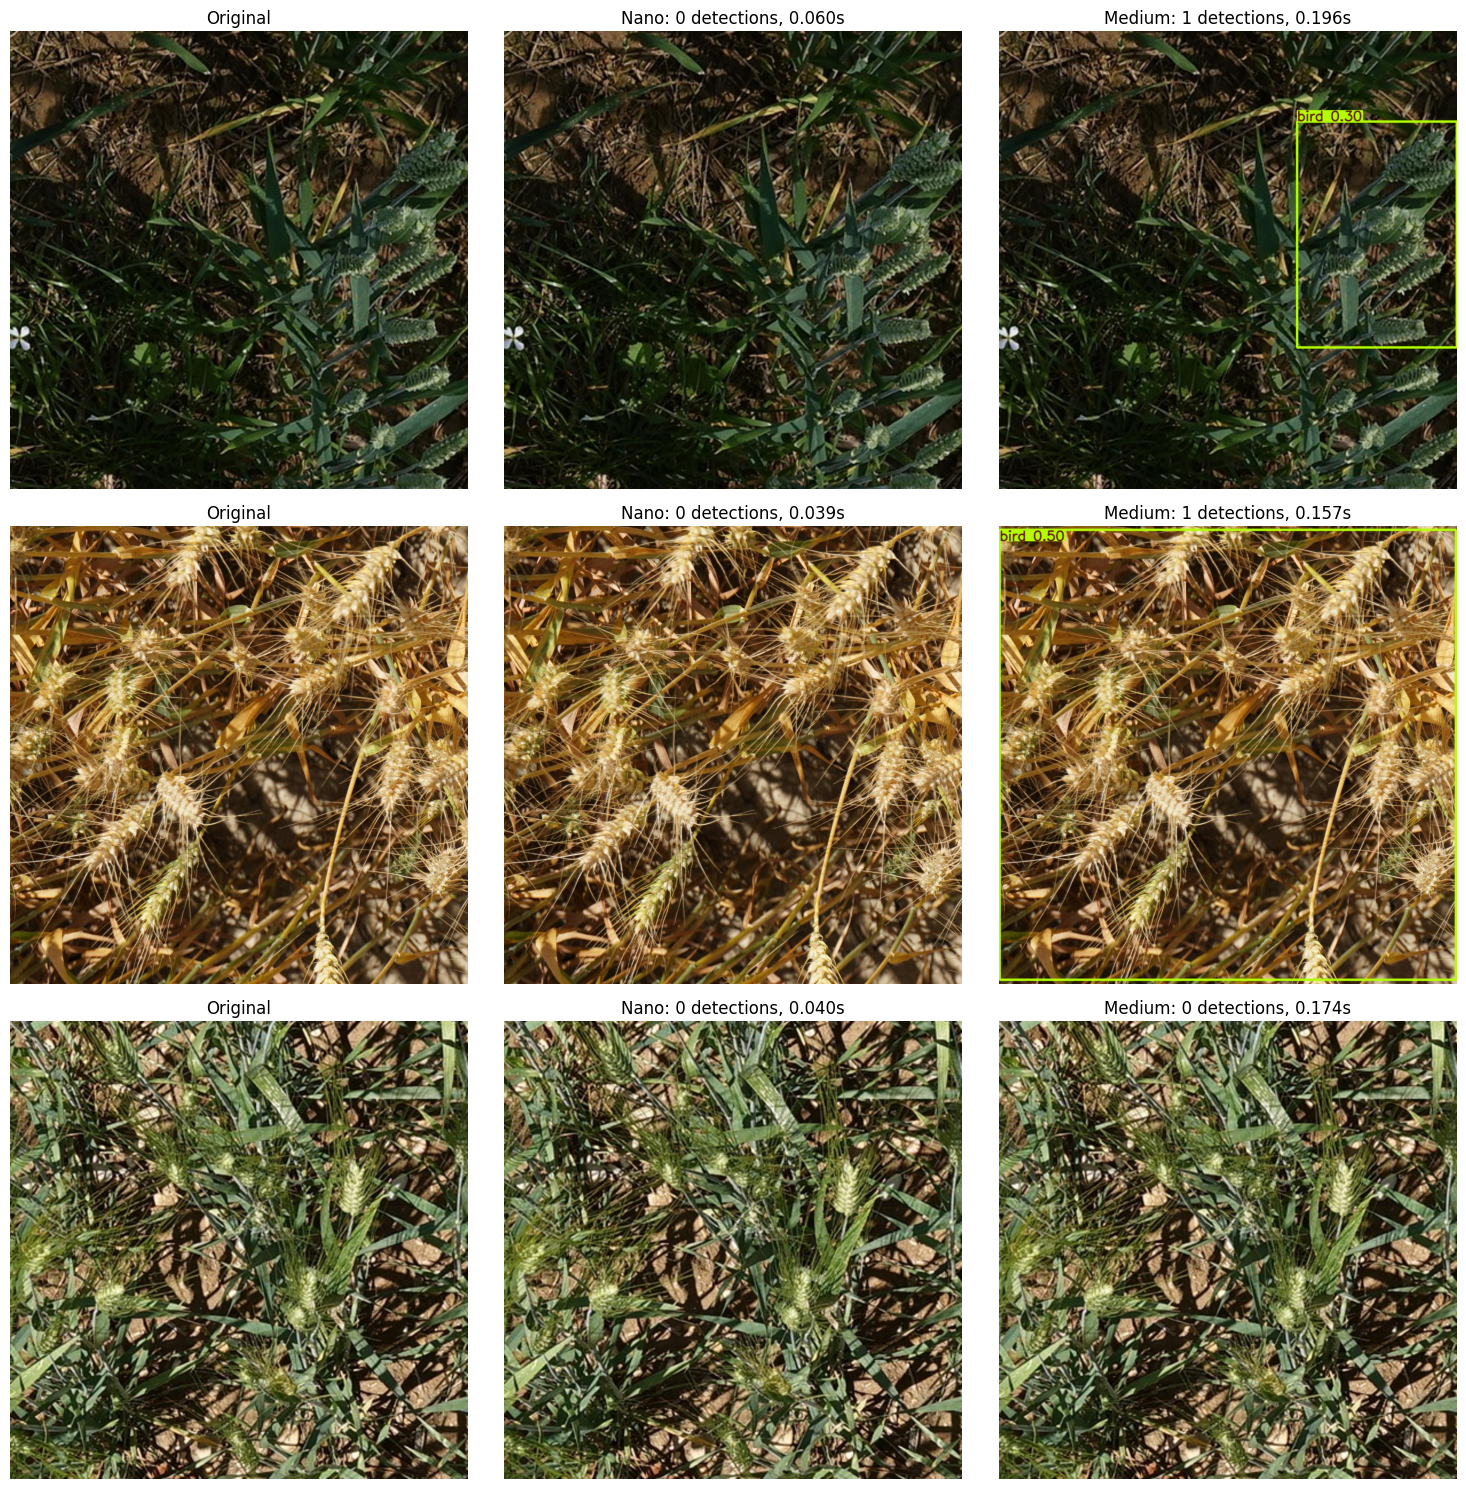

In [11]:
import time

model_nano = YOLO('yolo11n.pt')
model_medium = YOLO('yolo11m.pt')

test_imgs = images[:3]
times_nano = []
times_medium = []
detections_nano = []
detections_medium = []

for img in test_imgs:
    start = time.time()
    result_nano = model_nano(img, conf=0.25, verbose=False)[0]
    times_nano.append(time.time() - start)
    detections_nano.append(len(result_nano.boxes))
    
    start = time.time()
    result_medium = model_medium(img, conf=0.25, verbose=False)[0]
    times_medium.append(time.time() - start)
    detections_medium.append(len(result_medium.boxes))

print(f"Nano - Avg time: {np.mean(times_nano):.3f}s, Total detections: {sum(detections_nano)}")
print(f"Medium - Avg time: {np.mean(times_medium):.3f}s, Total detections: {sum(detections_medium)}")
print("Note: These detections are from COCO classes (birds, people, etc.), NOT wheat heads.")
print("For wheat detection, we need to fine-tune (section 7).")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    axes[i, 0].imshow(test_imgs[i])
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(model_nano(test_imgs[i], conf=0.25, verbose=False)[0].plot())
    axes[i, 1].set_title(f'Nano: {detections_nano[i]} detections, {times_nano[i]:.3f}s')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(model_medium(test_imgs[i], conf=0.25, verbose=False)[0].plot())
    axes[i, 2].set_title(f'Medium: {detections_medium[i]} detections, {times_medium[i]:.3f}s')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


## 7. YOLO Fine-tuning


In [12]:
import shutil

image_files = list(TRAIN_DIR.glob('*.jpg'))
np.random.seed(42)
np.random.shuffle(image_files)

n_train = int(len(image_files) * 0.7)
n_val = int(len(image_files) * 0.15)

train_files = image_files[:n_train]
val_files = image_files[n_train:n_train+n_val]
test_files = image_files[n_train+n_val:]

dataset_dir = Path('wheat_dataset')
for split in ['train', 'val', 'test']:
    (dataset_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (dataset_dir / split / 'labels').mkdir(parents=True, exist_ok=True)

for img_path in train_files:
    shutil.copy(img_path, dataset_dir / 'train' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'train' / 'labels' / label_path.name)

for img_path in val_files:
    shutil.copy(img_path, dataset_dir / 'val' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'val' / 'labels' / label_path.name)

for img_path in test_files:
    shutil.copy(img_path, dataset_dir / 'test' / 'images' / img_path.name)
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, dataset_dir / 'test' / 'labels' / label_path.name)

yaml_content = f"""path: {dataset_dir.absolute()}
train: train/images
val: val/images
test: test/images
nc: 1
names:
  0: wheat_head
"""

with open(dataset_dir / 'data.yaml', 'w') as f:
    f.write(yaml_content)


### Training Configuration

Set these flags to control whether to run training. Training will be skipped if the model already exists.


In [13]:
# Training configuration flags
# Set to True to enable training, False to skip
# Training will automatically skip if model already exists
TRAIN_INITIAL = False  # First training (POC: 5 epochs, imgsz=320, batch=128)
TRAIN_FINAL = False    # Second training (Full: 50 epochs, imgsz=640, batch=16)

# Model paths
INITIAL_MODEL_PATH = Path("runs/detect/train/weights/best.pt")
FINAL_MODEL_PATH = Path("runs/detect/train2/weights/best.pt")

print("Training Configuration:")
print(f"  TRAIN_INITIAL: {TRAIN_INITIAL} (model exists: {INITIAL_MODEL_PATH.exists()})")
print(f"  TRAIN_FINAL:   {TRAIN_FINAL} (model exists: {FINAL_MODEL_PATH.exists()})")
print()
if INITIAL_MODEL_PATH.exists() and TRAIN_INITIAL:
    print(f"⚠️  Initial model already exists at {INITIAL_MODEL_PATH}")
    print("   Set TRAIN_INITIAL=False to skip training, or delete the model to retrain.")
if FINAL_MODEL_PATH.exists() and TRAIN_FINAL:
    print(f"⚠️  Final model already exists at {FINAL_MODEL_PATH}")
    print("   Set TRAIN_FINAL=False to skip training, or delete the model to retrain.")


Training Configuration:
  TRAIN_INITIAL: False (model exists: True)
  TRAIN_FINAL:   False (model exists: False)



In [14]:
# First Training (POC - Quick test)
if TRAIN_INITIAL and not INITIAL_MODEL_PATH.exists():
    import os
    import torch

    # Set environment for maximum MPS performance
    os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

    device = 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu'
    workers = 4  # macOS multiprocessing limitation - 4-8 is usually max
    batch_size = 128 if device == 'mps' else 64  # Increased for faster training
    imgsz = 320  # Smaller = faster (was 512, can use 320 for even faster POC)

    print("="*80)
    print("STARTING INITIAL TRAINING (POC)")
    print("="*80)
    print(f"Device: {device}")
    print(f"Workers: {workers}")
    print(f"Batch size: {batch_size}")
    print(f"Image size: {imgsz}")
    print()

    model = YOLO('yolo11n.pt')

    results = model.train(
    data=str(dataset_dir / 'data.yaml'),
    epochs=5,  # Fewer epochs for POC
    imgsz=imgsz,
    batch=batch_size,
    patience=3,  # Lower patience for POC
    device=device,
    workers=workers,
    amp=True,  # CRITICAL: Enable mixed precision for ~2x speedup
    cache='disk',  # Faster than RAM cache with 0 workers
    plots=False,
    save_period=5,
    close_mosaic=0,  # Disable mosaic closing (saves time)
    val=False,  # Already disabled - good!
    
    # Disable expensive augmentations for speed
    mosaic=0.0,  # Disable mosaic augmentation
    mixup=0.0,   # Disable mixup
    copy_paste=0.0,  # Disable copy-paste
    degrees=0.0,  # Disable rotation
    translate=0.0,  # Disable translation
    scale=0.0,  # Disable scaling
    fliplr=0.0,  # Disable horizontal flip
    hsv_h=0.0,  # Disable HSV augmentation
    hsv_s=0.0,
    hsv_v=0.0,
    
    # Other speed optimizations
    verbose=False,  # Less logging overhead
    deterministic=False,  # Slightly faster without determinism
    )
    
    metrics = model.val()
    print(f"\nFinal Metrics:")
    print(f"mAP@50: {metrics.box.map50:.4f}")
    print(f"mAP@50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    
    print("\n" + "="*80)
    print("INITIAL TRAINING COMPLETED")
    print("="*80)
elif INITIAL_MODEL_PATH.exists():
    print(f"✓ Initial model already exists at {INITIAL_MODEL_PATH}")
    print("  Skipping initial training. Set TRAIN_INITIAL=True and delete the model to retrain.")
else:
    print("⚠️  Initial training is disabled (TRAIN_INITIAL=False)")
    print("  Set TRAIN_INITIAL=True to enable training.")


✓ Initial model already exists at runs/detect/train/weights/best.pt
  Skipping initial training. Set TRAIN_INITIAL=True and delete the model to retrain.


In [15]:
# Second Training (Full - Production quality)
if TRAIN_FINAL and not FINAL_MODEL_PATH.exists():
    print("\n" + "="*80)
    print("STARTING FINAL TRAINING (Full)")
    print("="*80)
    print("Configuration: 50 epochs, imgsz=640, batch=16, full augmentations")
    print()
    
    model = YOLO('yolo11n.pt')

    results = model.train(
        data=str(dataset_dir / 'data.yaml'),
        epochs=50,
        imgsz=640,
        batch=16,
        patience=20
    )
    
    print("\n" + "="*80)
    print("FINAL TRAINING COMPLETED")
    print("="*80)
elif FINAL_MODEL_PATH.exists():
    print(f"\n✓ Final model already exists at {FINAL_MODEL_PATH}")
    print("  Skipping final training. Set TRAIN_FINAL=True and delete the model to retrain.")
else:
    print("\n⚠️  Final training is disabled (TRAIN_FINAL=False)")
    print("  Set TRAIN_FINAL=True to enable training.")



⚠️  Final training is disabled (TRAIN_FINAL=False)
  Set TRAIN_FINAL=True to enable training.


## 8. Example Usage - Inference with Trained Model


In [16]:
# Load the best trained model (automatically selects available model)
from pathlib import Path

# Check which models exist (prefer final/train2, fallback to initial/train)
final_model_path = Path("runs/detect/train2/weights/best.pt")
initial_model_path = Path("runs/detect/train/weights/best.pt")

if final_model_path.exists():
    best_model_path = str(final_model_path)
    model_name = "Final (train2)"
elif initial_model_path.exists():
    best_model_path = str(initial_model_path)
    model_name = "Initial (train)"
else:
    raise FileNotFoundError(
        "No trained model found! Please run training first.\n"
        f"  Expected locations:\n"
        f"    - {final_model_path}\n"
        f"    - {initial_model_path}\n"
        f"  Set TRAIN_INITIAL=True or TRAIN_FINAL=True and run the training cells."
    )

trained_model = YOLO(best_model_path)
print(f"✓ Loaded {model_name} model from: {best_model_path}")

# Run inference on a few test images
test_images = list((dataset_dir / 'test' / 'images').glob('*.jpg'))[:3]  # Get first 3 test images

for img_path in test_images:
    # Run prediction
    results = trained_model(str(img_path))
    
    # Visualize results
    results[0].show()
    
    # Print detection info
    print(f"\nImage: {img_path.name}")
    print(f"Detections: {len(results[0].boxes)}")
    
    if len(results[0].boxes) > 0:
        for i, box in enumerate(results[0].boxes[:5]):  # Show first 5 detections
            conf = float(box.conf[0])
            bbox = box.xyxy[0].tolist()
            print(f"  Detection {i+1}: confidence={conf:.3f}, bbox={[round(x, 1) for x in bbox]}")
    else:
        print("  No detections")
    print("-" * 50)


✓ Loaded Initial (train) model from: runs/detect/train/weights/best.pt

image 1/1 /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/test/images/a7436f5c7.jpg: 320x320 15 wheat_heads, 13.1ms
Speed: 0.6ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)

Image: a7436f5c7.jpg
Detections: 15
  Detection 1: confidence=0.712, bbox=[318.9, 545.5, 435.5, 670.2]
  Detection 2: confidence=0.562, bbox=[55.5, 295.4, 154.5, 394.5]
  Detection 3: confidence=0.542, bbox=[203.1, 311.5, 286.4, 415.1]
  Detection 4: confidence=0.532, bbox=[202.5, 433.8, 291.4, 551.7]
  Detection 5: confidence=0.496, bbox=[807.0, 322.7, 895.4, 427.0]
--------------------------------------------------

image 1/1 /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/test/images/6895c563e.jpg: 320x320 37 wheat_heads, 16.1ms
Speed: 0.8ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 320)

Image: 6895c563e.jpg
Detections: 37
  Detection 1: confidence=0.826, bbox=

## 9. Comparison: Initial vs Final Training Scores


⚠️ Final model (train2) not found. Skipping comparison - only showing initial model metrics.
   (You can skip the second training if you want, but results will be lower quality)

Loading Initial Model (train)...
Evaluating Initial Model...
Ultralytics 8.3.235 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3763.8±1511.5 MB/s, size: 152.7 KB)
val: Scanning /Users/drazenbaric/Projects/upz-pdp/wheat_dataset/val/labels.cache... 513 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 513/513 1.5Mit/s 0.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 1.2it/s 26.7s0.8ss
                   all        513      21356      0.833      0.687      0.757      0.343
Speed: 0.1ms preprocess, 42.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /Users/drazenbaric/Projects/upz-pdp/runs

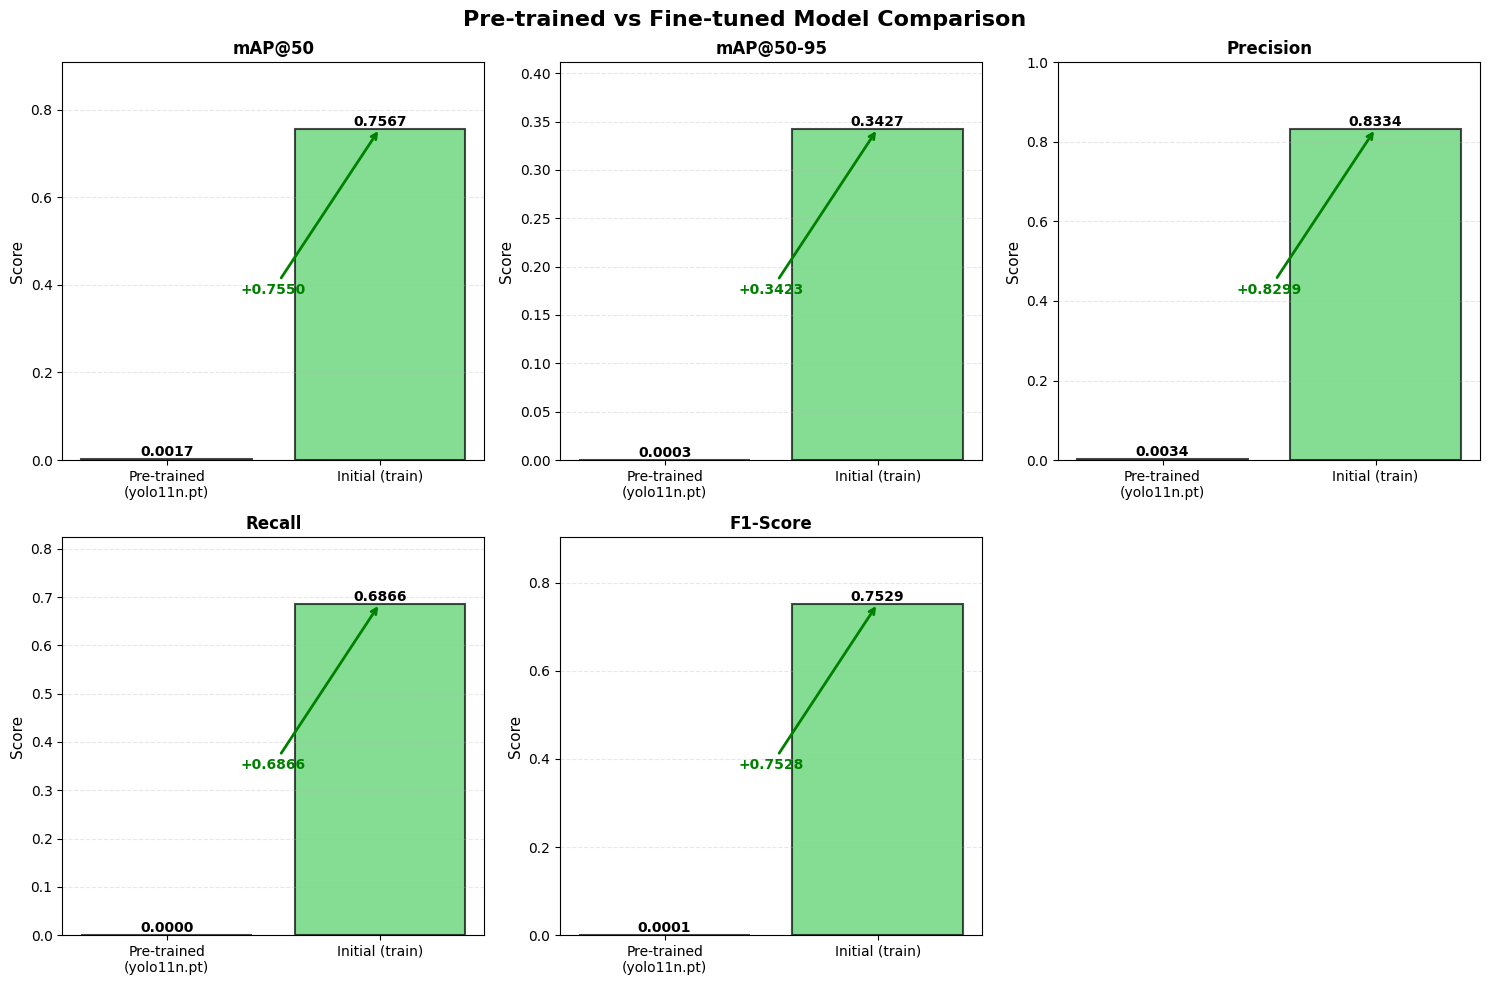


FINE-TUNING IMPACT SUMMARY
Pre-trained model: yolo11n.pt (COCO dataset - 80 classes, NOT trained on wheat)
Fine-tuned model: Initial (train) (trained on wheat detection dataset)

Key Improvements from Fine-tuning:
  ✓ Precision: +0.8299 (+24233.9% relative)
  ✓ mAP@50: +0.7550 (+43976.5% relative)
  ✓ F1-Score: +0.7528 (+814828.5% relative)
  ✓ Recall: +0.6866 (+1466200.0% relative)
  ✓ mAP@50-95: +0.3423 (+99703.6% relative)


In [17]:
# Load models (check if both exist)
initial_model_path = "runs/detect/train/weights/best.pt"
final_model_path = "runs/detect/train2/weights/best.pt"

from pathlib import Path

initial_exists = Path(initial_model_path).exists()
final_exists = Path(final_model_path).exists()

if not initial_exists and not final_exists:
    print("⚠️ No trained models found. Please run training first.")
elif not initial_exists:
    print("⚠️ Initial model (train) not found. Only final model available.")
elif not final_exists:
    print("⚠️ Final model (train2) not found. Skipping comparison - only showing initial model metrics.")
    print("   (You can skip the second training if you want, but results will be lower quality)")
else:
    print("✓ Both models found. Running comparison...")

# Load and evaluate initial model
if initial_exists:
    print("\nLoading Initial Model (train)...")
    initial_model = YOLO(initial_model_path)
    print("Evaluating Initial Model...")
    initial_metrics = initial_model.val(data=str(dataset_dir / 'data.yaml'))

# Load and evaluate final model (if exists)
if final_exists:
    print("\nLoading Final Model (train2)...")
    final_model = YOLO(final_model_path)
    print("Evaluating Final Model...")
    final_metrics = final_model.val(data=str(dataset_dir / 'data.yaml'))

# Extract metrics
if initial_exists:
    initial_map50 = initial_metrics.box.map50
    initial_map = initial_metrics.box.map
    initial_precision = initial_metrics.box.mp
    initial_recall = initial_metrics.box.mr
    initial_f1 = 2 * (initial_precision * initial_recall) / (initial_precision + initial_recall + 1e-10)

if final_exists:
    final_map50 = final_metrics.box.map50
    final_map = final_metrics.box.map
    final_precision = final_metrics.box.mp
    final_recall = final_metrics.box.mr
    final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall + 1e-10)

# Also evaluate pre-trained model (before fine-tuning) for comparison
pretrained_model_path = "yolo11n.pt"
pretrained_exists = Path(pretrained_model_path).exists()

if pretrained_exists:
    print("\nEvaluating Pre-trained Model (before fine-tuning)...")
    pretrained_model = YOLO(pretrained_model_path)
    pretrained_metrics = pretrained_model.val(data=str(dataset_dir / 'data.yaml'))
    
    pretrained_map50 = pretrained_metrics.box.map50
    pretrained_map = pretrained_metrics.box.map
    pretrained_precision = pretrained_metrics.box.mp
    pretrained_recall = pretrained_metrics.box.mr
    pretrained_f1 = 2 * (pretrained_precision * pretrained_recall) / (pretrained_precision + pretrained_recall + 1e-10)

# Only show comparison if both models exist
if not (initial_exists and final_exists):
    if initial_exists:
        print("\n" + "="*80)
        print("INITIAL MODEL METRICS (train)")
        print("="*80)
        print(f"mAP@50:     {initial_map50:.4f}")
        print(f"mAP@50-95:  {initial_map:.4f}")
        print(f"Precision:  {initial_precision:.4f}")
        print(f"Recall:     {initial_recall:.4f}")
        print("="*80)
        print("\nNote: This is a POC training (5 epochs, imgsz=320).")
        print("      For better results, run the second training (50 epochs, imgsz=640).")
    elif final_exists:
        print("\n" + "="*80)
        print("FINAL MODEL METRICS (train2)")
        print("="*80)
        print(f"mAP@50:     {final_map50:.4f}")
        print(f"mAP@50-95:  {final_map:.4f}")
        print(f"Precision:  {final_precision:.4f}")
        print(f"Recall:     {final_recall:.4f}")
        print("="*80)

# Pre-trained vs Fine-tuned comparison (if pre-trained model exists and at least one fine-tuned model exists)
if pretrained_exists and (initial_exists or final_exists):
    print("\n" + "="*80)
    print("PRE-TRAINED vs FINE-TUNED COMPARISON")
    print("="*80)
    
    # Use final model if available, otherwise use initial
    if final_exists:
        fine_tuned_map50 = final_map50
        fine_tuned_map = final_map
        fine_tuned_precision = final_precision
        fine_tuned_recall = final_recall
        fine_tuned_f1 = final_f1
        model_name = "Final (train2)"
    else:
        fine_tuned_map50 = initial_map50
        fine_tuned_map = initial_map
        fine_tuned_precision = initial_precision
        fine_tuned_recall = initial_recall
        fine_tuned_f1 = initial_f1
        model_name = "Initial (train)"
    
    pretuned_comparison = {
        'Metric': ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score'],
        'Pre-trained (yolo11n.pt)': [
            f'{pretrained_map50:.4f}',
            f'{pretrained_map:.4f}',
            f'{pretrained_precision:.4f}',
            f'{pretrained_recall:.4f}',
            f'{pretrained_f1:.4f}'
        ],
        f'{model_name}': [
            f'{fine_tuned_map50:.4f}',
            f'{fine_tuned_map:.4f}',
            f'{fine_tuned_precision:.4f}',
            f'{fine_tuned_recall:.4f}',
            f'{fine_tuned_f1:.4f}'
        ],
        'Improvement': [
            f'{fine_tuned_map50 - pretrained_map50:+.4f}',
            f'{fine_tuned_map - pretrained_map:+.4f}',
            f'{fine_tuned_precision - pretrained_precision:+.4f}',
            f'{fine_tuned_recall - pretrained_recall:+.4f}',
            f'{fine_tuned_f1 - pretrained_f1:+.4f}'
        ],
        'Improvement %': [
            f'{((fine_tuned_map50 - pretrained_map50) / pretrained_map50 * 100):+.2f}%' if pretrained_map50 > 0 else 'N/A',
            f'{((fine_tuned_map - pretrained_map) / pretrained_map * 100):+.2f}%' if pretrained_map > 0 else 'N/A',
            f'{((fine_tuned_precision - pretrained_precision) / pretrained_precision * 100):+.2f}%' if pretrained_precision > 0 else 'N/A',
            f'{((fine_tuned_recall - pretrained_recall) / pretrained_recall * 100):+.2f}%' if pretrained_recall > 0 else 'N/A',
            f'{((fine_tuned_f1 - pretrained_f1) / pretrained_f1 * 100):+.2f}%' if pretrained_f1 > 0 else 'N/A'
        ]
    }
    
    pretuned_df = pd.DataFrame(pretuned_comparison)
    print(pretuned_df.to_string(index=False))
    print("="*80)
    
    # Visualize pre-trained vs fine-tuned
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    fig2.suptitle('Pre-trained vs Fine-tuned Model Comparison', fontsize=16, fontweight='bold')
    
    metrics_pt = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score']
    pretrained_values = [pretrained_map50, pretrained_map, pretrained_precision, pretrained_recall, pretrained_f1]
    finetuned_values = [fine_tuned_map50, fine_tuned_map, fine_tuned_precision, fine_tuned_recall, fine_tuned_f1]
    
    for idx, metric in enumerate(metrics_pt):
        ax = axes2.flat[idx]
        x = ['Pre-trained\n(yolo11n.pt)', f'{model_name}']
        y = [pretrained_values[idx], finetuned_values[idx]]
        colors = ['#ff6b6b', '#51cf66']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_ylim([0, max(y) * 1.2])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Add improvement arrow
        improvement = finetuned_values[idx] - pretrained_values[idx]
        if improvement != 0:
            arrow_color = 'green' if improvement > 0 else 'red'
            ax.annotate(f'{improvement:+.4f}',
                       xy=(1, finetuned_values[idx]),
                       xytext=(0.5, (pretrained_values[idx] + finetuned_values[idx])/2),
                       arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2),
                       fontsize=10, fontweight='bold', color=arrow_color,
                       ha='center')
    
    # Hide the 6th subplot (we only have 5 metrics)
    axes2.flat[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("FINE-TUNING IMPACT SUMMARY")
    print("="*80)
    print(f"Pre-trained model: yolo11n.pt (COCO dataset - 80 classes, NOT trained on wheat)")
    print(f"Fine-tuned model: {model_name} (trained on wheat detection dataset)")
    print("\nKey Improvements from Fine-tuning:")
    pt_improvements = {
        'mAP@50': fine_tuned_map50 - pretrained_map50,
        'mAP@50-95': fine_tuned_map - pretrained_map,
        'Precision': fine_tuned_precision - pretrained_precision,
        'Recall': fine_tuned_recall - pretrained_recall,
        'F1-Score': fine_tuned_f1 - pretrained_f1
    }
    pt_initial_vals = {'mAP@50': pretrained_map50, 'mAP@50-95': pretrained_map, 'Precision': pretrained_precision, 'Recall': pretrained_recall, 'F1-Score': pretrained_f1}
    
    for metric, improvement in sorted(pt_improvements.items(), key=lambda x: abs(x[1]), reverse=True):
        if improvement > 0:
            rel_improvement = (improvement / pt_initial_vals[metric] * 100) if pt_initial_vals[metric] > 0 else 0
            print(f"  ✓ {metric}: +{improvement:.4f} (+{rel_improvement:.1f}% relative)")
        elif improvement < 0:
            rel_change = (improvement / pt_initial_vals[metric] * 100) if pt_initial_vals[metric] > 0 else 0
            print(f"  ✗ {metric}: {improvement:.4f} ({rel_change:.1f}% relative)")
        else:
            print(f"  = {metric}: no change")
    print("="*80)

if initial_exists and final_exists:
    # Both models exist - show comparison
    # Create comparison table
    comparison_data = {
    'Metric': ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score'],
    'Initial (train)': [
        f'{initial_map50:.4f}',
        f'{initial_map:.4f}',
        f'{initial_precision:.4f}',
        f'{initial_recall:.4f}',
        f'{initial_f1:.4f}'
    ],
    'Final (train2)': [
        f'{final_map50:.4f}',
        f'{final_map:.4f}',
        f'{final_precision:.4f}',
        f'{final_recall:.4f}',
        f'{final_f1:.4f}'
    ],
    'Improvement': [
        f'{final_map50 - initial_map50:+.4f}',
        f'{final_map - initial_map:+.4f}',
        f'{final_precision - initial_precision:+.4f}',
        f'{final_recall - initial_recall:+.4f}',
        f'{final_f1 - initial_f1:+.4f}'
    ],
    'Improvement %': [
        f'{((final_map50 - initial_map50) / initial_map50 * 100):+.2f}%' if initial_map50 > 0 else 'N/A',
        f'{((final_map - initial_map) / initial_map * 100):+.2f}%' if initial_map > 0 else 'N/A',
        f'{((final_precision - initial_precision) / initial_precision * 100):+.2f}%' if initial_precision > 0 else 'N/A',
        f'{((final_recall - initial_recall) / initial_recall * 100):+.2f}%' if initial_recall > 0 else 'N/A',
        f'{((final_f1 - initial_f1) / initial_f1 * 100):+.2f}%' if initial_f1 > 0 else 'N/A'
    ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL COMPARISON: Initial vs Final Training")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Comparison: Initial vs Final Training', fontsize=16, fontweight='bold')
    
    metrics = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score']
    initial_values = [initial_map50, initial_map, initial_precision, initial_recall, initial_f1]
    final_values = [final_map50, final_map, final_precision, final_recall, final_f1]
    
    for idx, metric in enumerate(metrics):
        ax = axes.flat[idx]
        x = ['Initial\n(train)', 'Final\n(train2)']
        y = [initial_values[idx], final_values[idx]]
        colors = ['#ff6b6b', '#51cf66']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_ylim([0, max(y) * 1.2])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Add improvement arrow
        improvement = final_values[idx] - initial_values[idx]
        if improvement != 0:
            arrow_color = 'green' if improvement > 0 else 'red'
            ax.annotate(f'{improvement:+.4f}',
                       xy=(1, final_values[idx]),
                       xytext=(0.5, (initial_values[idx] + final_values[idx])/2),
                       arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2),
                       fontsize=10, fontweight='bold', color=arrow_color,
                       ha='center')
    
    # Hide the 6th subplot (we only have 5 metrics)
    axes.flat[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"Initial Training: 5 epochs, imgsz=320, batch=128, minimal augmentations")
    print(f"Final Training:   50 epochs, imgsz=640, batch=16, full augmentations")
    print("\nKey Improvements:")
    improvements = {
        'mAP@50': final_map50 - initial_map50,
        'mAP@50-95': final_map - initial_map,
        'Precision': final_precision - initial_precision,
        'Recall': final_recall - initial_recall,
        'F1-Score': final_f1 - initial_f1
    }
    # Calculate relative improvements
    initial_vals = {'mAP@50': initial_map50, 'mAP@50-95': initial_map, 'Precision': initial_precision, 'Recall': initial_recall, 'F1-Score': initial_f1}
    
    for metric, improvement in sorted(improvements.items(), key=lambda x: abs(x[1]), reverse=True):
        if improvement > 0:
            rel_improvement = (improvement / initial_vals[metric] * 100) if initial_vals[metric] > 0 else 0
            print(f"  ✓ {metric}: +{improvement:.4f} (+{rel_improvement:.1f}% relative)")
        elif improvement < 0:
            rel_change = (improvement / initial_vals[metric] * 100) if initial_vals[metric] > 0 else 0
            print(f"  ✗ {metric}: {improvement:.4f} ({rel_change:.1f}% relative, needs attention)")
        else:
            print(f"  = {metric}: no change")
    print("="*80)
